In [21]:
from gen_model_playground.fit.vae import VAE
from gen_model_playground.models import Model
from gen_model_playground.data import TwoMoonsDataModule
from sklearn.datasets import make_moons
import torch
from my_cmaps import cmap
vae=VAE.load_from_checkpoint("/beegfs/desy/user/kaechben/thesis_experiments/thesis_experiments/6ldp39bj/checkpoints/last.ckpt").cuda()

gen=vae.decoder.cuda()
disc=Model(2,1).cuda()
loss=torch.nn.BCEWithLogitsLoss()
opt_vae=torch.optim.Adam(vae.parameters(),lr=1e-3)

data_module=TwoMoonsDataModule(1000,100)
data_module.setup("valid")

In [24]:
for i in range(5):
    for x,_ in data_module.train_dataloader():
        with torch.no_grad():
            x=x.cuda()
        xhat=vae.decoder(vae.encoder(x))

        loss_=(x-xhat).pow(2).mean()
        opt_vae.zero_grad()
        loss_.backward()
        opt_vae.step()

    print(loss_)





tensor(0.0130, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0065, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0151, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0098, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0056, device='cuda:0', grad_fn=<MeanBackward0>)


tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5296e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1400e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.3527e-06, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.0944e-06, device='cuda:0', grad_fn=<AddBackward0>)


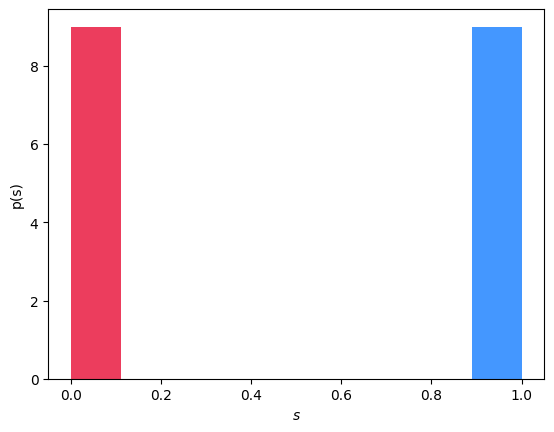

In [36]:
opt=torch.optim.Adam(disc.parameters(),lr=1e-2)

for i in range(5):
    for x,_ in data_module.train_dataloader():
        with torch.no_grad():
            x=x.cuda()
            xhat=vae.decoder(vae.encoder((x)))

        loss_disc=loss(disc(x),torch.ones(1000,1,device="cuda"))+loss(disc(xhat),torch.zeros(1000,1,device="cuda"))
        opt.zero_grad()
        loss_disc.backward()
        opt.step()

    print(loss_disc)
s=[]
s_real=[]
for x,_ in data_module.train_dataloader():
    with torch.no_grad():
        x=x.cuda()
        xhat=vae.decoder(vae.encoder((x)))


        s.append(torch.nn.functional.sigmoid(disc(xhat).cpu()))
        s_real.append(torch.nn.functional.sigmoid(disc(x).cpu()))
s=torch.cat(s).numpy()
s_real=torch.cat(s_real).numpy()


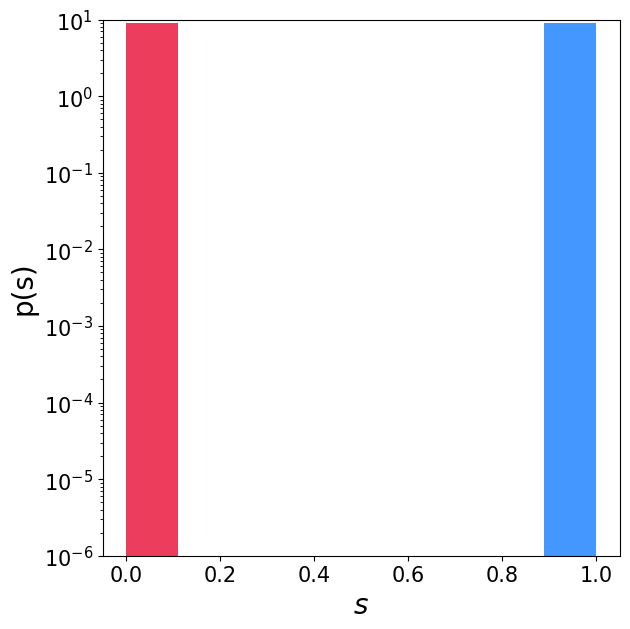

In [55]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(6.4,6.4))
plt.hist(s_real,bins=np.linspace(0,1,10),density=1)
plt.hist(s,bins=np.linspace(0,1,10),density=1)
import os
os.makedirs("../gen_model_playground/plots/manifolds/",exist_ok=True)
plt.xlabel(r"$s$",fontsize=20)
plt.ylabel(r"p(s)",fontsize=20)
plt.yscale("log")
plt.ylim(1e-6,1e1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig("../gen_model_playground/plots/manifolds/scores.pdf")

plt.show()

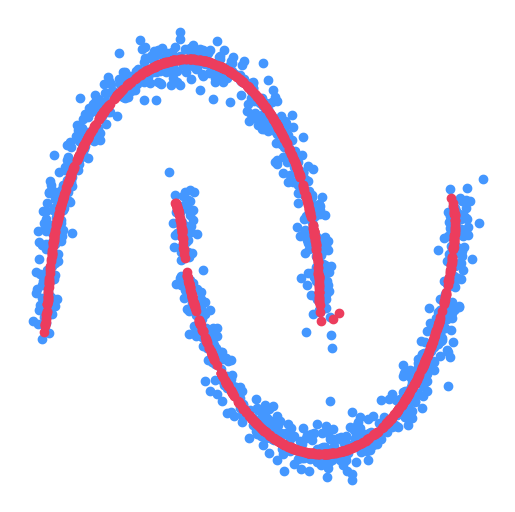

In [53]:
plt.figure(figsize=(6.4,6.4))

plt.scatter(x.detach().cpu().numpy()[:,0],x.detach().cpu().numpy()[:,1])

plt.scatter(xhat.detach().cpu().numpy()[:,0],xhat.detach().cpu().numpy()[:,1])
plt.axis("off")
plt.savefig("../gen_model_playground/plots/manifolds/data.pdf")
plt.show()